In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler

# Functions

In [2]:
def filter_outliers(data):
    q1_prix, q2_prix, q3_prix, q4_prix = data.prix.quantile([0.25, 0.5, 0.75, 1])
    iqr_prix = q3_prix - q1_prix
    lower_prix = q1_prix- 1.5*iqr_prix
    upper_prix = q3_prix + 1.5*iqr_prix
    data_filtered = data.query('prix>=@lower_prix and prix<=@upper_prix')
    return data_filtered

def randomized_search(estimator_, X_train_, y_train_, param_grid_, cv_, verbose_, n_jobs_, n_iter_, scoring_='neg_mean_squared_error', random_state=1, error_score='raise'):
    estimator_grid = RandomizedSearchCV(estimator=estimator_, param_distributions=param_grid_,
                       cv=cv_, scoring=scoring_, error_score='raise',
                       verbose=verbose_, n_jobs=n_jobs_, n_iter=n_iter_, random_state=seed)
    estimator_grid.fit(X_train_, y_train_)
    return estimator_grid.best_estimator_, estimator_grid.best_params_

def cross_val_rmse_(model_, X_train_, y_train_, cv_, scoring_='neg_mean_squared_error'):
    model_cv_scores = cross_val_score(model_, X_train_, y_train_, cv=cv_, scoring=scoring_)
    model_rmse = np.sqrt(-model_cv_scores.mean())
    return model_rmse

def cross_val_rmse_score_printer(models, n_folds, X_train, y_train):
    models_rmses = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_rmse = cross_val_rmse_(model, X_train, y_train, cv_=n_folds)
        models_rmses[name] = model_rmse
    for key, value in models_rmses.items():
        print(f"\033[1m{key}\033[0m cross-validation RMSE: \033[1m{value:.2f}\033[0m")
    return models_rmses

# Load the data

In [3]:
data = pd.read_csv("real_estate_PML.csv")
data.head()
keys = ['Très Petit', 'Petit', 'Moyen', 'Grand', 'Très Grand' ]
values = [1,2,3,4,5]
mapped_dict = dict(zip(keys, values))

# Outliers removal

In [4]:
paris, lyon, mrs = data.loc[data['ville']=='Paris',].copy(), data.loc[data['ville']=='Lyon',].copy(), data.loc[data['ville']=='Marseille',].copy()
paris.shape, lyon.shape, mrs.shape

((2921, 8), (2176, 8), (876, 8))

In [5]:
paris_filtered = filter_outliers(paris)
lyon_filtered = filter_outliers(lyon)
mrs_filtered = filter_outliers(mrs)


In [6]:
paris_filtered.shape, lyon_filtered.shape, mrs_filtered.shape

((2691, 8), (2053, 8), (798, 8))

In [7]:
df = pd.concat([paris_filtered, lyon_filtered, mrs_filtered], axis=0, ignore_index=True)
data.shape, df.shape

((5973, 8), (5542, 8))

# Dummies

In [8]:
dummy = pd.get_dummies(df['ville'], dtype=float)
df = pd.concat([dummy, df], axis=1).drop(['type_l', 'prix_m2', 'ville'], axis=1)

In [9]:
df.loc[df['n_pieces']==0, 'n_pieces'] = 1
df.n_pieces.value_counts()

n_pieces
3.0     1775
2.0     1388
4.0     1127
1.0      716
5.0      447
6.0       73
7.0       12
8.0        2
10.0       1
25.0       1
Name: count, dtype: int64

# Data split and scaling

In [10]:
features = [col for col in df.columns if col != 'prix']
seed = 4
X_train, X_test, y_train, y_test = train_test_split(df[features].values, df.prix.values, test_size=0.1, random_state=seed)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Establish base models

In [12]:
lreg = LinearRegression()
ridge = Ridge(alpha=0.5)
dt = DecisionTreeRegressor(random_state=seed)
rf = RandomForestRegressor(random_state=seed)
knr = KNeighborsRegressor()

In [13]:
# RMSE on non-scaled features
models = {'Linear Regresion': LinearRegression(),
          'Ridge': Ridge(alpha=0.5),
          'Decision Tree Regressor': DecisionTreeRegressor(random_state=25),
          'Random Forest Regressor': RandomForestRegressor(random_state=25),
          'KNeighbors Regressor': KNeighborsRegressor()}
non_scaled_10cv_rmse = cross_val_rmse_score_printer(models, n_folds=10, X_train=X_train, y_train=y_train)

Linear Regresion cross-validation RMSE: 178253.24
Ridge cross-validation RMSE: 178242.89
Decision Tree Regressor cross-validation RMSE: 152698.03
Random Forest Regressor cross-validation RMSE: 123497.89
KNeighbors Regressor cross-validation RMSE: 187496.45


In [14]:
# RMSE on scaled features
scaled_10cv_rmse = cross_val_rmse_score_printer(models, n_folds=10, X_train=X_train_scaled, y_train=y_train)

Linear Regresion cross-validation RMSE: 178240.85
Ridge cross-validation RMSE: 178242.80
Decision Tree Regressor cross-validation RMSE: 152347.31
Random Forest Regressor cross-validation RMSE: 123485.64
KNeighbors Regressor cross-validation RMSE: 134014.34


# Add new feature

In [15]:
containers = [0,20,40,80,160,df['surface_m2'].max()]
df['largeur'] = pd.cut(df['surface_m2'], containers, labels = keys)
df['largeur']=df['largeur'].map(mapped_dict)
df.head()

,Lyon,Marseille,Paris,arr,n_pieces,n_chambres,surface_m2,prix,largeur
0,0.0,0.0,1.0,17,3.0,1.0,51.84,535000.0,3
1,0.0,0.0,1.0,15,3.0,2.0,40.77,470000.0,3
2,0.0,0.0,1.0,13,2.0,1.0,39.00,385000.0,2
3,0.0,0.0,1.0,13,2.0,1.0,36.03,383000.0,2
4,0.0,0.0,1.0,10,2.0,1.0,40.70,399000.0,3


In [16]:
new_features = [col for col in df.columns if col!='prix']
X_new = df[new_features].values
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, df.prix.values, test_size=0.1, random_state=seed)
X_new_train_scaled = scaler.fit_transform(X_new_train)
X_new_test_scaled = scaler.transform(X_new_test)

In [17]:
scaled_10cv_rmse_new_features = cross_val_rmse_score_printer(models, n_folds=10, X_train=X_new_train_scaled, y_train=y_new_train)

Linear Regresion cross-validation RMSE: 175810.46
Ridge cross-validation RMSE: 175807.90
Decision Tree Regressor cross-validation RMSE: 152095.05
Random Forest Regressor cross-validation RMSE: 123401.32
KNeighbors Regressor cross-validation RMSE: 134971.16


## Comment on results


# Hyper parameter Tuning

In [18]:
# Linear Models.
knr.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [19]:
ridge_param = {
    'alpha':[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 50],
    'solver':['svd', 'cholesky', 'saga']}

dt_params = {
    'max_depth':range(1,20),
    'min_samples_leaf':[0.1, 0.2, 0.3, 0.5, 0.8, 1],
    'min_samples_split':[2, 3, 5, 10]}

rf_params = {
    'bootstrap':[True, False],
    'ccp_alpha':[0.2, 0.4, 0.6, 0.8, 1],
    'max_depth':[1, 2, 4, 6, 8, 10, 12, 14, 15],
    'min_samples_leaf':[0.2, 0.4, 0.6, 0.8, 1],
    'n_estimators':[20, 50, 100, 250, 500]}

knr_params = {
    'algorithm':['ball_tree', 'kd_tree'],
    'leaf_size':[10,20,30],
    'n_neighbors':[1,3,5,10,15]}
params_list = [ridge_param, dt_params, rf_params, knr_params]

In [20]:
new_models = {
          'Ridge': Ridge(alpha=0.5),
          'Decision Tree Regressor': DecisionTreeRegressor(random_state=25),
          'Random Forest Regressor': RandomForestRegressor(random_state=25),
          'KNeighbors Regressor': KNeighborsRegressor()}

best_model_dict = {}
best_hyper_params = []

for (key,val), parameters in zip(new_models.items(), params_list):
    best_model, model_best_hp = randomized_search(val, X_new_train_scaled, y_new_train, param_grid_=parameters, cv_=5, verbose_=0, n_jobs_=-1, n_iter_= 150)
    best_model_dict[key] = best_model
    model_best_hp['model'] = key
    best_hyper_params.append(model_best_hp)

C:\NKT\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=150. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\NKT\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=150. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Explore Gradient Boosting and Adaptive Boosting for a stacking model

In [21]:
gb = GradientBoostingRegressor(random_state=seed)
ada = AdaBoostRegressor(random_state=seed)
best_hyper_params

[{'solver': 'svd', 'alpha': 10, 'model': 'Ridge'},
 {'min_samples_split': 10,
  'min_samples_leaf': 1,
  'max_depth': 8,
  'model': 'Decision Tree Regressor'},
 {'n_estimators': 100,
  'min_samples_leaf': 1,
  'max_depth': 12,
  'ccp_alpha': 0.2,
  'bootstrap': True,
  'model': 'Random Forest Regressor'},
 {'n_neighbors': 10,
  'leaf_size': 10,
  'algorithm': 'kd_tree',
  'model': 'KNeighbors Regressor'}]

In [22]:
boost_models = {
    'Gradient Boosting Regressor': gb,
    'Ada Boosting':ada}

gb_params = {
    'learning_rate':[0.01, 0.05, 0.1, 0.2],
    'ccp_alpha':[0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth':range(2,11),
    'min_weight_fraction_leaf':[0.01, 0.05, 0.1, 0.2],
    'n_estimators':range(10,210,10)}

dt_base = DecisionTreeRegressor(random_state=seed, max_depth=3)
dt_best = DecisionTreeRegressor(max_depth=8, min_samples_split=3, random_state=seed)

ada_params = {
    'estimator':[dt_base, dt_best],
    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5],
    'n_estimators':range(10,110, 10)}

boosting_param_list = [gb_params, ada_params]
best_boost_dict = {}
best_boost_hp = []


for (key,val), parameters in zip(boost_models.items(), boosting_param_list):
    best_model, model_best_hp = randomized_search(val, X_new_train_scaled, y_new_train, param_grid_=parameters, cv_=5, verbose_=0, n_jobs_=-1, n_iter_= 50)
    best_boost_dict[key] = best_model
    model_best_hp['model']=key
    best_boost_hp.append(model_best_hp)

In [23]:
all_models_dict = {}
for key, value in best_boost_dict.items():
    all_models_dict[key]=value
for key, value in best_model_dict.items():
    all_models_dict[key]=value

In [24]:
all_models_rmse_10_folds = cross_val_rmse_score_printer(all_models_dict, n_folds=10, X_train=X_train_scaled, y_train=y_train)

Gradient Boosting Regressor cross-validation RMSE: 124652.41
Ada Boosting cross-validation RMSE: 125870.64
Ridge cross-validation RMSE: 178238.94
Decision Tree Regressor cross-validation RMSE: 136691.21
Random Forest Regressor cross-validation RMSE: 122297.05
KNeighbors Regressor cross-validation RMSE: 134600.31


## Stacking Regressor

In [25]:
level_0 = [('GBR', all_models_dict['Gradient Boosting Regressor']), ('ADA', all_models_dict['Ada Boosting']), ('RF', all_models_dict['Random Forest Regressor'])]
level_1 = lreg
stack_model = StackingRegressor(estimators=level_0, final_estimator=level_1, cv=10)


In [26]:
all_models_dict

{'Gradient Boosting Regressor': GradientBoostingRegressor(ccp_alpha=0.1, learning_rate=0.2, max_depth=5,
                           min_weight_fraction_leaf=0.01, n_estimators=110,
                           random_state=4),
 'Ada Boosting': AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=8,
                                                   min_samples_split=3,
                                                   random_state=4),
                   learning_rate=0.5, n_estimators=70, random_state=4),
 'Ridge': Ridge(alpha=10, solver='svd'),
 'Decision Tree Regressor': DecisionTreeRegressor(max_depth=8, min_samples_split=10, random_state=25),
 'Random Forest Regressor': RandomForestRegressor(ccp_alpha=0.2, max_depth=12, random_state=25),
 'KNeighbors Regressor': KNeighborsRegressor(algorithm='kd_tree', leaf_size=10, n_neighbors=10)}

In [27]:
stack_rmse = cross_val_rmse_(stack_model, X_train_scaled, y_train, 10, scoring_='neg_mean_squared_error')
print(f"Stacking Regressor RMSE: {stack_rmse}")

Stacking Regressor RMSE: 120249.10170755854


In [28]:
final_models = {
    'Random Forest': all_models_dict['Random Forest Regressor'],
    'Gradient Boost': all_models_dict['Gradient Boosting Regressor'],
    'Stacking': stack_model
}

In [29]:
rmses_test = {}
rmses_train = {}
y_predicts = {}
y_train_predicts = {}
for name, model in final_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    rmse_y = mean_squared_error(y_test, y_pred, squared=False)
    rmse_y_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmses_test[name] = rmse_y
    rmses_train[name] = rmse_y_train
    y_predicts[name] = y_pred
    y_train_predicts[name] = y_train_pred

for key, value in rmses_test.items():
    print(f"{key} RMSE on test data: {value}")
print(f"{'-'*50}")
for key, value in rmses_train.items():
     print(f"{key} RMSE on train data: {value}")

Random Forest RMSE on test data: 110279.99773289979
Gradient Boost RMSE on test data: 118573.6170242369
Stacking RMSE on test data: 111260.44472854063
--------------------------------------------------
Random Forest RMSE on train data: 70272.5225141315
Gradient Boost RMSE on train data: 110475.70052253379
Stacking RMSE on train data: 84038.57306746754


In [30]:
for key, value in y_predicts.items():
    y_predicts[key]=value.tolist()
df_predicts = pd.DataFrame(y_predicts)
df_predicts['y_test'] = y_test
df_predicts.columns = df_predicts.columns.str.lower().str.replace(" ","_")

In [31]:
for key, value in y_train_predicts.items():
    y_train_predicts[key]=value.tolist()

In [32]:
df_train_predicts = pd.DataFrame(y_train_predicts)
df_train_predicts['y_test'] = y_train
df_train_predicts.columns = df_train_predicts.columns.str.lower().str.replace(" ","_")

In [33]:
df_train_predicts.head()

,random_forest,gradient_boost,stacking,y_test
0,634243.259602,680112.520462,659214.077171,598000.0
1,362413.282627,341318.533809,353935.405138,370000.0
2,309095.568952,295896.532229,302173.660375,290000.0
3,365904.959191,362823.214598,375142.571639,364000.0
4,358784.241380,448669.746525,400341.860398,370000.0


In [34]:
for col in df_predicts.columns:
    df_predicts[col] = np.round(df_predicts[col], 2)
    df_train_predicts[col] = np.round(df_train_predicts[col], 2)

In [35]:
cols = [col for col in df_predicts.columns if col!='y_test']
for col in cols:
    col_err = col+'_error'
    col_rmse = col+'_rmse'
    df_predicts[col_err] = np.abs(df_predicts[col] - df_predicts['y_test'])
    df_train_predicts[col_err] = np.abs(df_train_predicts[col] - df_train_predicts['y_test'])

In [36]:
df_predicts.head()

,random_forest,gradient_boost,stacking,y_test,random_forest_error,gradient_boost_error,stacking_error
0,130253.51,116836.81,124300.73,143000.0,12746.49,26163.19,18699.27
1,561070.73,645056.92,591265.95,715000.0,153929.27,69943.08,123734.05
2,435808.34,482185.27,450504.08,661500.0,225691.66,179314.73,210995.92
3,218770.19,205216.67,212205.56,194250.0,24520.19,10966.67,17955.56
4,810850.17,848556.49,834209.24,920000.0,109149.83,71443.51,85790.76


In [40]:
df_pred_sorted = df_predicts.sort_values("y_test").reset_index(drop=True)
df_pred_sorted_first_100 = df_pred_sorted.loc[:100,]

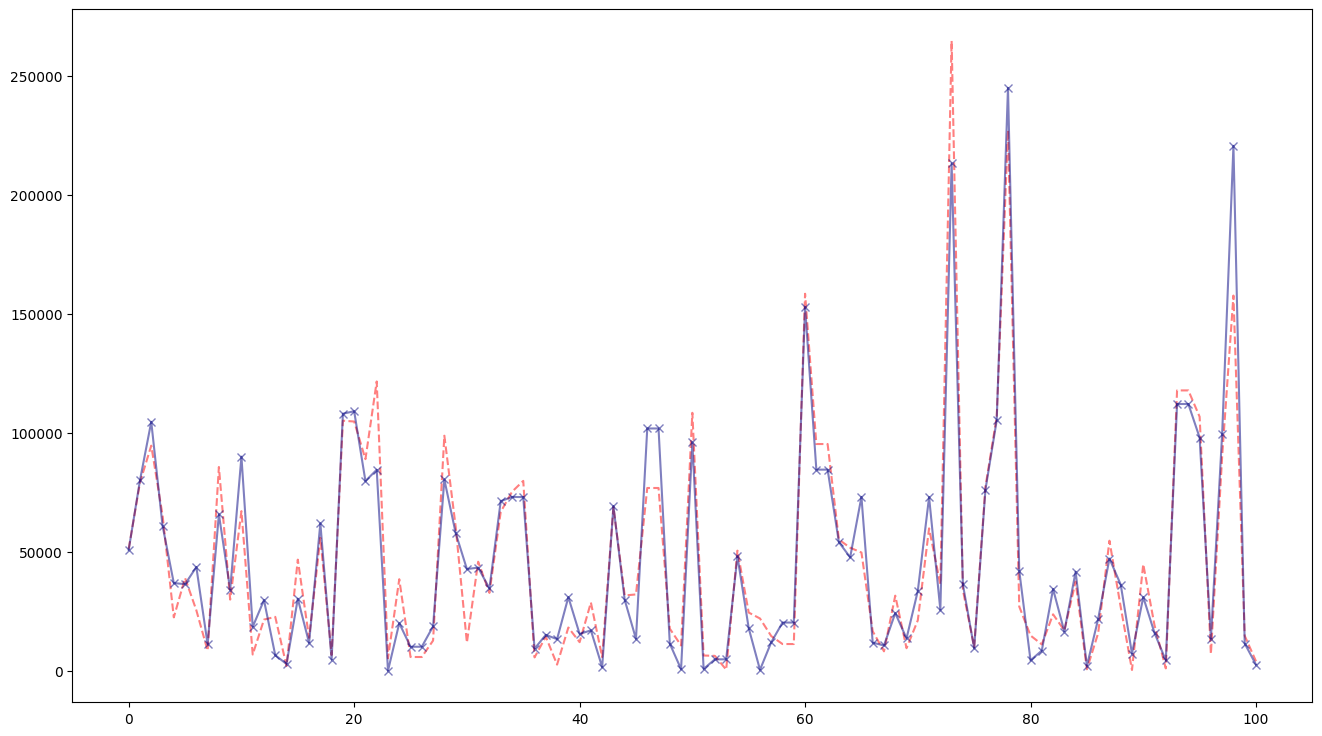

In [38]:
plt.subplots(figsize=(16,9))
plt.plot(df_pred_sorted_first_100.index, df_pred_sorted_first_100.random_forest_error, label='Random Forest',
         color='red', linestyle = '--', alpha = 0.5)
plt.plot(df_pred_sorted_first_100.index, df_pred_sorted_first_100.stacking_error, label='Stacking',
         color='navy', marker = 'x', alpha=0.5)
plt.show()


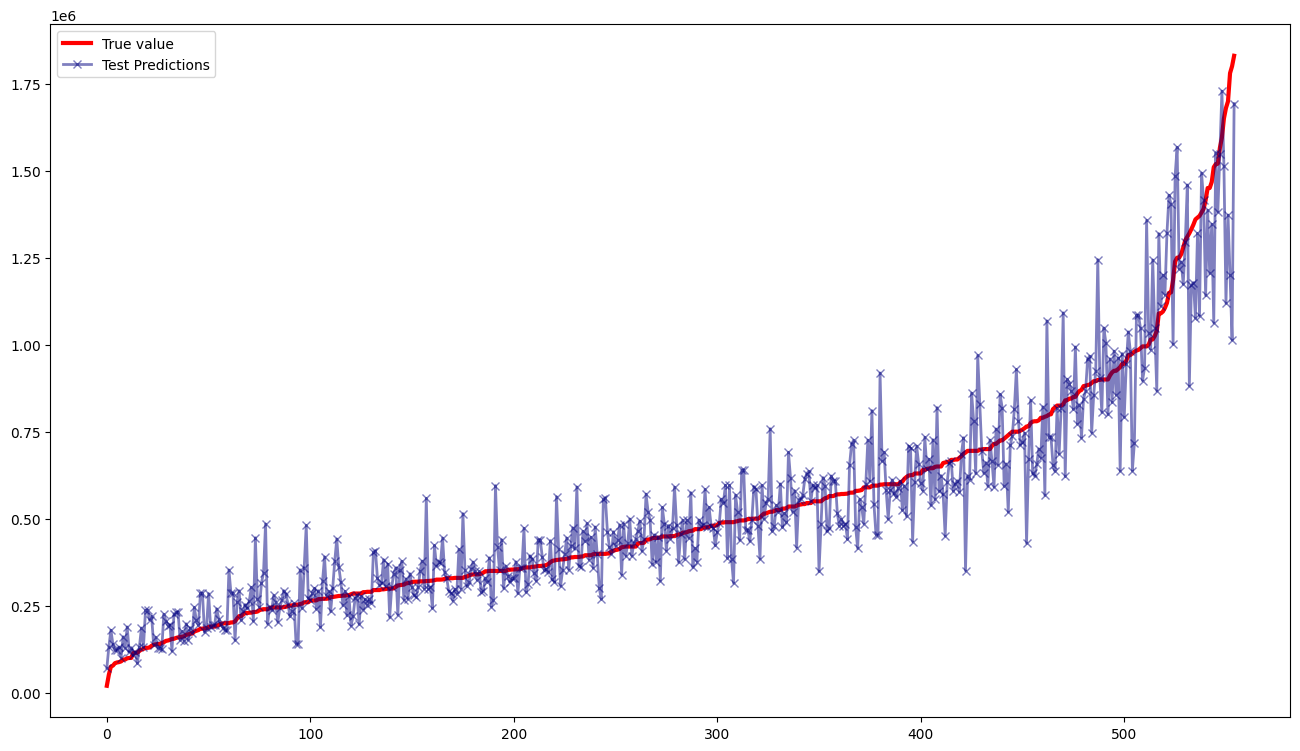

In [45]:
plt.subplots(figsize=(16,9))
plt.plot(df_pred_sorted.index, df_pred_sorted.y_test, color='red', label='True value', linewidth=3)
plt.plot(df_pred_sorted.index, df_pred_sorted.stacking, color = 'navy', marker='x', alpha=0.5, label='Test Predictions', linewidth=2)
plt.legend()
plt.show()
